Chapter 21
# Confidence Intervals

Much of machine learning involves estimating the performance of a machine learning algorithm on unseen data.  Confidence intervals are a way of quantifying the uncertainty of an estimate.  They can be used to add a bounds or likelihood on a population parameter, such as a mean, estimated from a sample of independent observations from the population.

A confidence interval is different from:
- a tolerance interval that describes the bounds of data sampled from the distribution
- a prediction interval that describes the bounds on a single observation

Instead, the confidence interval provides bounds on a population parameter, such as a mean or standard deviation.

A confidence interval could be used in presenting the skill of a classification model, which could be stated as:
- given the sample, there is a 95% likelihood that the range x to y covers the true model accuracy
- the accuracy of the model was x +/- y at the 95% confidence level

Confidence intervals can also be used in the presentation of the error of a regression predictive model:
- there is a 95% likelihood that the range x to y covers the true error of the model
- the error of the model was x +/- y at the 95% confidence level

The choice of 95% confidence is very common in presenting confidence intervals, although other less common values are used e.g. 90% or 99.7%

The value of a confidence interval is its ability to quantify the uncertainty of the estimate.  It provides both a lower and upper bound and a likelihood.

The confidence interval is often referred to as the margin of error, and may be used to graphically depict the uncertainty of an estimate on graphs through the use of error bars.

Often, the large the sample from which the estimate was drawn, the more precise the estimate and the smaller (better) the confidence interval:
- Smaller Confidence Interval - a more precise estimate
- Larger Confidence Interval - a less precise estimate

Confidence intervals may be preferred in practice over the use of statistical significance tests, as they are easier for practitioners and stakeholders to relate directly to the domain.  They can also be interpreted and used to compare machine learning models.

# Interval for Classification Accuracy
Classification problems are those where a label or class outcome variable is predicted given some input data.  It is common to use classification accuracy or classification error (the inverse of accuracy) to describe the skill of a classification predictive model:
- accuracy = (total correct predictions)/(total predictions made) * 100

This accuracy can be calculated based on a hold-out dataset not seen by the model during training, such as a validation or test dataset.

Each prediction is a binary decision that could be correct or incorrect: technically, this is called a Bernouilli trial.  The proportions in a Bernouilli trial have a specific distribution called a binomial distribution.  Thus, this is technically called the Binomical proportion confidence interval.

With large sample sizes (e.g. more than 30), we can approximate the distibution with a Gaussian.  We can use the assumption of a Gaussian distribution of the proportion to easily calculate the confidence interval.

For classification error:
- interval = z x sqrt((error x (1 - error))/n)

For classification accuracy:
- interval = z x sqrt((accuracy x (1 - accuracy))/n)

where z is a critical value from the Gaussian distribution.  Commonly used values include:
- 1.64 (90%)
- 1.96 (95%)
- 2.33 (98%)
- 2.58 (99%)

In [2]:
# Consider a model with an error of 20% on a validation dataset with 50 examples.  We can calculate the 95% confidence interval as follows
from math import sqrt

# calculate the interval
interval = 1.96 * sqrt( (0.2 * (1 - 0.2)) / 50)
print('Radius of confidence interval: %.3f' % interval)

# this allows us to make claims such as:
# - the classification error of the model is 20% +/- 11%
# - the true classification error of the model is likely between 9% and 31%

Radius of confidence interval: 0.111


In [3]:
# now repeat with a sample size of 100 to see the impact that the sample size has on the precision of the estimate, in terms of the radius of the confidence interval
from math import sqrt
interval = 1.96 * sqrt( (0.2 * (1 - 0.2)) / 100)
print('Radius of confidence interval: %.3f' % interval)

Radius of confidence interval: 0.078


The Statsmodels function proportion_confint() is an implementation of the binomial proportion confidence interval.  By default, it makes the Gaussian assumption for the Binomial distribution (although other more sophisticated variations are supported)

The function takes the following arguments:
- the count of successes (or failures)
- the total number of trials
- the significance level

and returns the lower and upper bound of the confidence interval

In [4]:
# Hypothetical example where a model made 88 correct predictions out of a dataset with 100 instances.  We are interested in the 95% confidence interval (passed to the function as a significance of 0.05)
from statsmodels.stats.proportion import proportion_confint

# calculate the interval
lower, upper = proportion_confint(88, 100, 0.05)
print('lower=%.3f, upper=%.3f' % (lower, upper))

lower=0.816, upper=0.944


# Nonparametric Confidence Interval
Often we do not know the distribution for a chosen performance measure, or may not know the analytical way to calculate a confidence interval for a skill score.

In these cases, the bootstrap resampling method can be used as a nonparametric method for calculating confidence intervals, nominally called bootstrap confidence intervals.  The bootstrap is a simulated Monte Carlo method where samples are drawn from a fixed finite dataset with replacement, and a parameter is estimated on each sample (see Chapter 17)

The procedure can be used to estimate the skill of a predictive model by fitting the model on each sample and evaluating the skill of the model on those samples not included in the sample.  The mean or median skill of the model can then be presented as an estimate of the model skill when evaluated on unseen data.  Confidence intervals can be added to this estimate by selecting observations from the sample of skill scores at specific percentiles.    

To calculate the bootstrap confidence interval, assume we have a dataset of 1000 observations of values between 0.5 and 1.0, drawn from a uniform distribution

We will perform the boostrap procedure 100 times, and draw samples of 1000 observations from the dataset with replacement.

We will estimate the mean of the population as the statistic we will calculate on the boostrap samples (this could just as easily be a model evaluation)

Once we have a sample of bootstrap statistics, we can calculate the central tendency.  As we do not assume any distribution, we will use the median or 50th percentile

We can then calculate the confidence interval as the middle 95% of observed statistical values centred around the median:
- first the desired lower percentile is calculated based on the chosen confidence interval
- then the observation at this percentile is retrieved from the sample of bootstrap statistics
- this is repeated for the upper boundary of the confidence interval

In [5]:
# bootstrap confidence intervals
from numpy.random import seed
from numpy.random import rand
from numpy.random import randint
from numpy import mean
from numpy import median
from numpy import percentile

# seed the random number generator
seed(1)

# generate dataset of 1000 observations of values between 0.5 and 1.0 drawn from a uniform distribution
dataset = 0.5 + rand(1000) * 0.5

# perform bootstrap procedure 100 times
scores = list()
for _ in range(100):

    # bootstrap sample of 1000 observations with replacement
    indices = randint(0, 1000, 1000)
    sample = dataset[indices]

    # calculate and store statistic
    statistic = mean(sample)
    scores.append(statistic)

# calculate the central tendency of the sample of bootstrap statistics, using the median (as we do not assume any distribution)
print('50th percentile (median) = %.3f' % median(scores))

# calculate 95% confidence intervals (100 - alpha)
alpha = 5.0

# calculate lower percentile (e.g. 2.5)
lower_p = alpha / 2.0

# retrieve observation at lower percentile
lower = max(0.0, percentile(scores, lower_p))
print('%.1fth percentile = %.3f' % (lower_p, lower))

# calculate upper percentile (e.g. 97.5)
upper_p = (100 - alpha) + (alpha / 2.0)

# retrieve observation at upper percentile
upper = min(1.0, percentile(scores, upper_p))
print('%.1fth percentile = %.3f' % (upper_p, upper))

# We can use these observations to make a claim about the sample distribution, such as:
# - there is a 95% likelihood that the range 0.741 to 0.757 covers the true statistic median

50th percentile (median) = 0.750
2.5th percentile = 0.741
97.5th percentile = 0.757


# Extensions

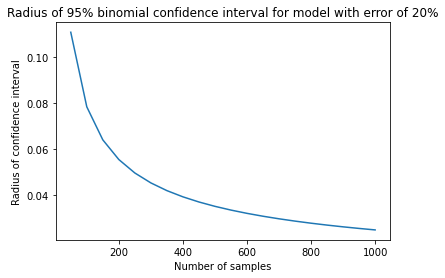

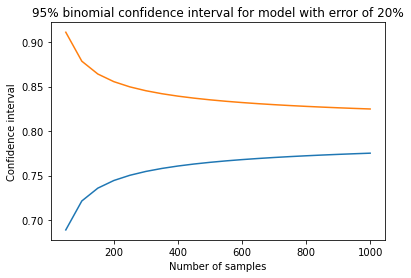

In [7]:
# 95% binomial confidence interval for model with error of 20% using formula
from math import sqrt
from matplotlib import pyplot as plt

num_samples = [50 * (i+1) for i in range(20)]
interval = []
lower_limit = []
upper_limit = []
for entry in num_samples:
    this_interval = 1.96 * sqrt( (0.2 * (1 - 0.2)) / entry)
    interval.append(this_interval)
    lower_limit.append(0.8-this_interval)
    upper_limit.append(0.8+this_interval)

plt.title('Radius of 95% binomial confidence interval for model with error of 20%')
plt.xlabel('Number of samples')
plt.ylabel('Radius of confidence interval')
plt.plot(num_samples, interval)
plt.show()

plt.title('95% binomial confidence interval for model with error of 20%')
plt.xlabel('Number of samples')
plt.ylabel('Confidence interval')
plt.plot(num_samples, lower_limit)
plt.plot(num_samples, upper_limit)
plt.show()

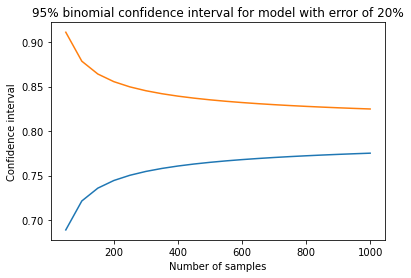

In [5]:
# 95% binomial confidence interval for model with error of 20% using statsmodels function
from statsmodels.stats.proportion import proportion_confint
from matplotlib import pyplot as plt

num_samples = [50 * (i+1) for i in range(20)]
lower_limit = []
upper_limit = []
for entry in num_samples:
    lower, upper = proportion_confint(0.8*entry, entry, 0.05)
    lower_limit.append(lower)
    upper_limit.append(upper)


plt.title('95% binomial confidence interval for model with error of 20%')
plt.xlabel('Number of samples')
plt.ylabel('Confidence interval')
plt.plot(num_samples, lower_limit)
plt.plot(num_samples, upper_limit)
plt.show()

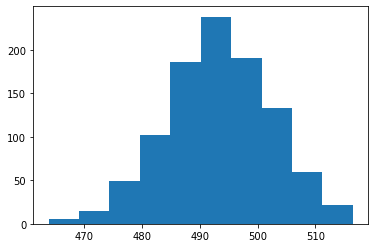

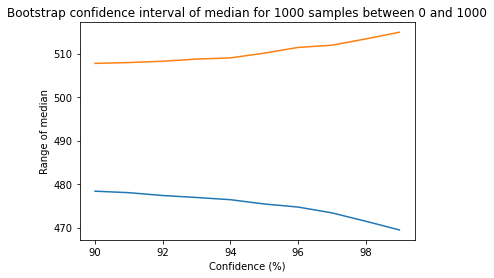

In [34]:
# bootstrap confidence intervals
from numpy.random import rand
from numpy.random import randint
from numpy import mean
from numpy import median
from numpy import percentile
from matplotlib import pyplot as plt
from statsmodels.graphics.gofplots import qqplot

def getrange(scores, alpha):
    # calculate lower percentile (e.g. 2.5)
    lower_p = alpha / 2.0

    # retrieve observation at lower percentile
    lower = max(0, percentile(scores, lower_p))

    # calculate upper percentile (e.g. 97.5)
    upper_p = (100 - alpha) + (alpha / 2.0)

    # retrieve observation at upper percentile
    upper = min(1000, percentile(scores, upper_p))

    # return lower and upper limit
    return lower, upper

# generate dataset of 1000 observations of values between 0 and 1000 drawn from a uniform distribution
dataset = rand(1000) * 1000

# perform bootstrap procedure 1000 times
scores = list()
for _ in range(1000):

    # bootstrap sample of 1000 observations with replacement
    indices = randint(0, 1000, 1000)
    sample = dataset[indices]

    # calculate and store statistic
    statistic = mean(sample)
    scores.append(statistic)

# plot scores
plt.hist(scores)
plt.show()

# calculate confidence intervals 
confidence = []
lower_limit = []
upper_limit = []
for alpha in range(1,11):
    # get lower and upper limit of confidence interval
    lower, upper = getrange(scores, alpha)
    lower_limit.append(lower)
    upper_limit.append(upper)
    confidence.append(100-alpha)

plt.title('Bootstrap confidence interval of median for 1000 samples between 0 and 1000')
plt.xlabel('Confidence (%)')
plt.ylabel('Range of median')
plt.plot(confidence, lower_limit)
plt.plot(confidence, upper_limit)
plt.show()